In [1]:
# Necessary imports
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from collections import Counter
from FuzzyTM import FLSA_W
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bvits\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bvits\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bvits\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# Imports
import pandas as pd

# Read IEEE files
df_books_NBool_IEEE = pd.read_csv('filtered_output_IEEE/filtered_IEEE(Books)_What are the components of microservice (no boolean).csv')
df_conference_Bool_IEEE = pd.read_csv('filtered_output_IEEE/filtered_IEEE(Conference)_What are the components of microservice (boolean).csv')
df_conference_NBool_IEEE = pd.read_csv('filtered_output_IEEE/filtered_IEEE(Conference)_What are the components of microservice (no boolean).csv')
df_journal_NBool_IEEE = pd.read_csv('filtered_output_IEEE/filtered_IEEE(Journals)_What are the components of microservice (no boolean).csv')

# Read ACM files
df_NBool_ACM = pd.read_csv('filtered_output/filtered_Microservices_nonbool.csv')
df_Bool_ACM = pd.read_csv('filtered_output/filtered_Microservices_bool.csv')

# Rename ACM columns to match IEEE format
acm_to_ieee = {
    'title': 'Document Title',
    'authors': 'Authors',
    'year': 'Publication Year',
    'journal': 'Publication Title',
    'abstract': 'Abstract',
    'doi': 'DOI'
}

df_NBool_ACM = df_NBool_ACM.rename(columns=acm_to_ieee)
df_Bool_ACM = df_Bool_ACM.rename(columns=acm_to_ieee)

# Add source and bool columns to ACM dataframes
df_NBool_ACM['source'] = 'ACM'
df_Bool_ACM['source'] = 'ACM'
df_NBool_ACM['bool'] = 'no'
df_Bool_ACM['bool'] = 'yes'

# Add source and bool columns to IEEE dataframes
df_conference_NBool_IEEE['source'] = 'IEEE conference'
df_journal_NBool_IEEE['source'] = 'IEEE journal'
df_books_NBool_IEEE['source'] = 'IEEE book'
df_conference_Bool_IEEE['source'] = 'IEEE conference'

df_conference_NBool_IEEE['bool'] = 'no'
df_journal_NBool_IEEE['bool'] = 'no'
df_books_NBool_IEEE['bool'] = 'no'
df_conference_Bool_IEEE['bool'] = 'yes'

# Essential columns for topic modeling (based on the code in TopicModelling_Microservice.ipynb)
essential_columns = ['Document Title', 'Abstract', 'source', 'bool']

# Function to ensure dataframe has all essential columns
def standardize_columns(df):
    for col in essential_columns:
        if col not in df.columns:
            df[col] = ''  # Add empty column if missing
    return df[essential_columns]

# Standardize all dataframes
dfs = [
    df_NBool_ACM, 
    df_Bool_ACM,
    df_conference_NBool_IEEE,
    df_journal_NBool_IEEE,
    df_books_NBool_IEEE,
    df_conference_Bool_IEEE
]

standardized_dfs = [standardize_columns(df) for df in dfs]

# Combine all dataframes
df = pd.concat(standardized_dfs, ignore_index=True)

# Remove any rows where Abstract or Document Title is empty
df = df.dropna(subset=['Abstract', 'Document Title'])

# Print info about the merged dataset
print(f"Total number of documents: {len(df)}")
print("\nSample of merged dataset:")
print(df.head())
print("\nDataset columns:")
print(df.columns.tolist())

Total number of documents: 490

Sample of merged dataset:
                                      Document Title  \
0  Vehicular-OBUs-As-On-Demand-Fogs: Resource and...   
1  SPRIGHT: High-Performance eBPF-Based Event-Dri...   
2  Zero+: Monitoring Large-Scale Cloud-Native Inf...   
3  DeepScaling: Autoscaling Microservices With St...   
4        Architectural Principles for Cloud Software   

                                            Abstract source bool  
0  Observing the headway in vehicular industry, n...    ACM   no  
1  Serverless computing promises an efficient, lo...    ACM   no  
2  Cloud services have shifted from monolithic de...    ACM   no  
3  Cloud service providers often provision excess...    ACM   no  
4  A cloud is a distributed Internet-based softwa...    ACM   no  

Dataset columns:
['Document Title', 'Abstract', 'source', 'bool']


In [4]:
# Preprocessing function
def preprocess_text(text):
    text = text.strip()
    # Replace URLs with empty string
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Tokenize
    words = word_tokenize(text.lower())
    # Remove non-alpha and convert to lowercase
    alpha_words = [word for word in words if word.isalpha()]
    # Remove numbers
    numbers_words = [word for word in alpha_words if not word.isdigit()]
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    stop_words_removed = [word for word in numbers_words if word not in stop_words]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in stop_words_removed]
    
    return lemmatized_words

# Combine title and abstract for analysis
df['text'] = df['Document Title'] + ' ' + df['Abstract']
df['processed_text'] = df['text'].apply(preprocess_text)

# Remove infrequent and too frequent words
# Remove infrequent and too frequent words
all_words = [word for content in df['processed_text'] for word in content]
word_freq = Counter(all_words)

min_freq = 3
max_freq = 0.7 * len(df)
filtered_words = {word for word, freq in word_freq.items() if min_freq <= freq <= max_freq}

def filter_content(content):
    return [word for word in content if word in filtered_words]

df['processed_text'] = df['processed_text'].apply(filter_content)
# Create document-term matrix
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['processed_text'].apply(lambda x: ' '.join(x)))



In [5]:
# 2. LDA
def get_topics(model, vectorizer, n_top_words):
    words = vectorizer.get_feature_names_out()
    topics = []
    for topic in model.components_:
        topic_words = [words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topics.append(topic_words)
    return topics

# Train LDA
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)

# Get LDA topics
lda_topics = get_topics(lda, vectorizer, 10)
print("\nLDA Topics:")
for idx, topic in enumerate(lda_topics):
    print(f"Topic {idx}: {' '.join(topic)}")





LDA Topics:
Topic 0: resource performance algorithm latency kubernetes container time network based load
Topic 1: distributed metric trace analysis based performance management deployment paper edge
Topic 2: computing design development using iot paper based model technology framework
Topic 3: network platform paper management framework business design based implementation using
Topic 4: model smart based development process tool platform using deployment case


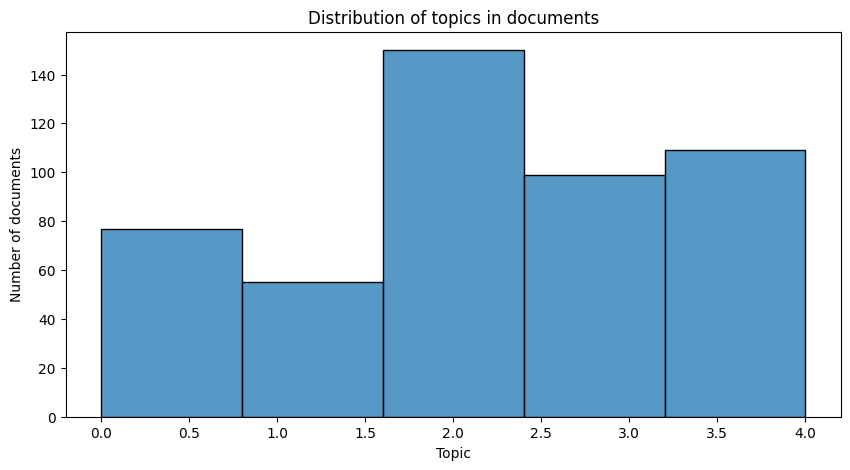

In [6]:

# Plot topic distribution
topic_dist = lda.transform(X)
dominant_topics = topic_dist.argmax(axis=1)

plt.figure(figsize=(10, 5))
sns.histplot(dominant_topics, bins=5)
plt.xlabel('Topic')
plt.ylabel('Number of documents')
plt.title('Distribution of topics in documents')
plt.show()

In [7]:
# Imports
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd
from umap import UMAP
from hdbscan import HDBSCAN
import matplotlib.pyplot as plt
from FuzzyTM import FLSA_W

c:\Users\bvits\OneDrive\Desktop\2024\Uni\thesis\thesis reading\compatibility of data products\Lit Review\Processing Docs\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
# Combine title and abstract for analysis 
df['text'] = df['Document Title'] + ' ' + df['Abstract']
docs = df['text'].tolist()

# Create BERTopic model with parameters from example
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine')
hdbscan_model = HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
vectorizer_model = CountVectorizer(stop_words="english")

topic_model = BERTopic(
    umap_model=umap_model, 
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    calculate_probabilities=True,
    verbose=True
)

# Fit model and get topics
topics, probs = topic_model.fit_transform(docs)


2025-01-25 17:32:10,010 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 16/16 [00:23<00:00,  1.44s/it]
2025-01-25 17:32:35,404 - BERTopic - Embedding - Completed ✓
2025-01-25 17:32:35,404 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-01-25 17:32:43,388 - BERTopic - Dimensionality - Completed ✓
2025-01-25 17:32:43,388 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-01-25 17:32:43,415 - BERTopic - Cluster - Completed ✓
2025-01-25 17:32:43,420 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-01-25 17:32:43,502 - BERTopic - Representation - Completed ✓


In [9]:
# Print topics info
print("Number of topics:", len(set(topics)))
print("\nTop terms per topic:")
print(topic_model.get_topic_info())



Number of topics: 5

Top terms per topic:
   Topic  Count                                               Name  \
0     -1     37  -1_microservices_architecture_components_approach   
1      0    245    0_architecture_applications_microservices_cloud   
2      1    133  1_microservices_architecture_software_microser...   
3      2     45                   2_anomaly_root_data_microservice   
4      3     30            3_security_service_microservices_attack   

                                      Representation  \
0  [microservices, architecture, components, appr...   
1  [architecture, applications, microservices, cl...   
2  [microservices, architecture, software, micros...   
3  [anomaly, root, data, microservice, cause, det...   
4  [security, service, microservices, attack, ser...   

                                 Representative_Docs  
0  [Easily Designing and Deploying AI enabled Net...  
1  [Internet of Things Services Orchestration Fra...  
2  [Analyzing Microservices and Mon

In [11]:
# Code that obtains the articles that belong to a specific topic as a dataframe
def get_topic_articles(topic, topics, docs, df):
    topic_articles = []
    for idx, t in enumerate(topics):
        if t == topic:
            topic_articles.append(docs[idx])
    text_df = pd.DataFrame(topic_articles, columns=['text'])
    topic_df = text_df.merge(df, on='text', how='left')
    return topic_df



# Get articles for topic 2
topic_0_articles = get_topic_articles(1, topics, docs, df)

# Merge with the original dataframe to get additional information

print("\nArticles for topic 0:")
print(topic_0_articles)



Articles for topic 0:
                                                  text  \
0    Dynamic Evaluation of Microservice Granularity...   
1    Actor-Driven Decomposition of Microservices th...   
2    MicroProf: Code-level Attribution of Unnecessa...   
3    Data Mesh: A Systematic Gray Literature Review...   
4    The structure and delivery of an advanced syst...   
..                                                 ...   
128  Implementing Event-Driven Microservices Archit...   
129  Software Architecture with C++: Design modern ...   
130  Event-Driven Architecture in Golang: Building ...   
131  Content Management System Architecture This ch...   
132  An Atypical ASP.NET Core 6 Design Patterns Gui...   

                                        Document Title  \
0    Dynamic Evaluation of Microservice Granularity...   
1    Actor-Driven Decomposition of Microservices th...   
2    MicroProf: Code-level Attribution of Unnecessa...   
3       Data Mesh: A Systematic Gray Literature 

In [13]:
import os

# Code to save the dataframe of topics to a file in the topics folder

# Create topics directory if it doesn't exist
if not os.path.exists('topics'):
    os.makedirs('topics')

# Iterate over all topics and save the dataframe to a CSV file
for topic in set(topics):
    topic_articles = get_topic_articles(topic, topics, docs, df)
    topic_articles.to_csv(f'topics/topic_{topic}.csv', index=False)